# Warpy: open-source Farcaster datasets

By running `python download.py`, you can download the Farcaster datasets. This notebook will walk you through the things you can do with it.


In [2]:
import os
import duckdb

if not os.path.exists('./datasets'):
    !python download.py
else:
    print('Datasets exists, continuing...')


Datasets exists, continuing...


In [3]:
# you can use duckdb to directly query the files with SQL
query = "select * from users order by random() limit 5"

with duckdb.connect('datasets/datasets.db') as con:
    print(con.sql(query).pl())

# Note: to use ChatGPT to write query for you, see query.py
# ex: `python query.py "get ten random users"`

shape: (5, 12)
┌───────┬───────────┬────────────┬──────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ fid   ┆ username  ┆ display_na ┆ pfp_url  ┆ … ┆ farcaster_ ┆ external_a ┆ registered ┆ location_ │
│ ---   ┆ ---       ┆ me         ┆ ---      ┆   ┆ address    ┆ ddress     ┆ _at        ┆ id        │
│ i64   ┆ str       ┆ ---        ┆ str      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│       ┆           ┆ str        ┆          ┆   ┆ str        ┆ str        ┆ i64        ┆ str       │
╞═══════╪═══════════╪════════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 3030  ┆ emon      ┆ emon       ┆ https:// ┆ … ┆ 0x55133d5B ┆ 0x60d02a61 ┆ 1665264771 ┆           │
│       ┆           ┆            ┆ i.seadn. ┆   ┆ B5C2b47CD8 ┆ 3da7181278 ┆ 970        ┆           │
│       ┆           ┆            ┆ io/gae/X ┆   ┆ eE5Fc37933 ┆ e9f48241fd ┆            ┆           │
│       ┆           ┆            ┆ D8bR5ohg ┆   ┆ 21…        ┆ cc…        ┆ 

In [6]:
# here's a fancier query: get all farcasters in new york
query = "SELECT * FROM users WHERE location_id IN (SELECT id FROM locations WHERE description LIKE '%Japan%') LIMIT 3;"

with duckdb.connect('datasets/datasets.db') as con:
    print(con.sql(query).pl())

shape: (3, 12)
┌───────┬───────────┬────────────┬──────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ fid   ┆ username  ┆ display_na ┆ pfp_url  ┆ … ┆ farcaster_ ┆ external_a ┆ registered ┆ location_ │
│ ---   ┆ ---       ┆ me         ┆ ---      ┆   ┆ address    ┆ ddress     ┆ _at        ┆ id        │
│ i64   ┆ str       ┆ ---        ┆ str      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│       ┆           ┆ str        ┆          ┆   ┆ str        ┆ str        ┆ i64        ┆ str       │
╞═══════╪═══════════╪════════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 7484  ┆ pierceswo ┆ PiercedCAT ┆ https:// ┆ … ┆ 0x0738C27A ┆ 0xdafa9e3d ┆ 1671567770 ┆ ChIJr-eHX │
│       ┆ rd        ┆            ┆ i.imgur. ┆   ┆ D059298552 ┆ ae493f0b9d ┆ 334        ┆ CDBGGARXv │
│       ┆           ┆            ┆ com/QpOb ┆   ┆ 63724c8a33 ┆ 6872eff4fd ┆            ┆ aiv8DydIw │
│       ┆           ┆            ┆ dH6.jpg  ┆   ┆ b6…        ┆ a0…        ┆ 

In [7]:
# you can also use pandas or polars to process things
# ex: get all users where they have at least 5 casts that contain "gjelina" or "erewhon"
import polars as pl

cast_query = "select * from casts"

with duckdb.connect('datasets/datasets.db') as con:
    cast_df = con.sql(cast_query).df()

# get all users where they have at least 5 casts that contain "gjelina" or "erewhon"
cast_df = cast_df[cast_df['text'].str.contains('gjelina|erewhon', case=False)]
cast_df = cast_df.groupby('author_fid').filter(lambda x: len(x) >= 5)
print(pl.DataFrame._from_pandas(cast_df))

# get the user info, then print it out
fids = cast_df['author_fid'].unique()
user_query = "select * from read_parquet('datasets/users.parquet')"
users_df = duckdb.query(user_query).df()
users_df = users_df[users_df['fid'].isin(fids)]
print(pl.DataFrame._from_pandas(users_df))


shape: (60, 6)
┌─────────────────┬─────────────────┬────────────────┬───────────────┬────────────┬────────────────┐
│ hash            ┆ thread_hash     ┆ text           ┆ timestamp     ┆ author_fid ┆ parent_hash    │
│ ---             ┆ ---             ┆ ---            ┆ ---           ┆ ---        ┆ ---            │
│ str             ┆ str             ┆ str            ┆ i64           ┆ i64        ┆ str            │
╞═════════════════╪═════════════════╪════════════════╪═══════════════╪════════════╪════════════════╡
│ 0xd913c709681ed ┆ 0xa75522564a761 ┆ @v you should  ┆ 1642197646067 ┆ 3          ┆ 0x82939b1b7c8e │
│ 094c979ee2c09ec ┆ 3a5b89e82c7f2fb ┆ get a coffee   ┆               ┆            ┆ eea68cd1a984a3 │
│ 47…             ┆ 3a…             ┆ mug o…         ┆               ┆            ┆ 351f…          │
│ 0xf75a80ff9b881 ┆ 0xceae07d6f3908 ┆ Erewhon!       ┆ 1647543862106 ┆ 3          ┆ 0xceae07d6f390 │
│ e43cee1aac105dd ┆ 2505038b1463b93 ┆                ┆               ┆      

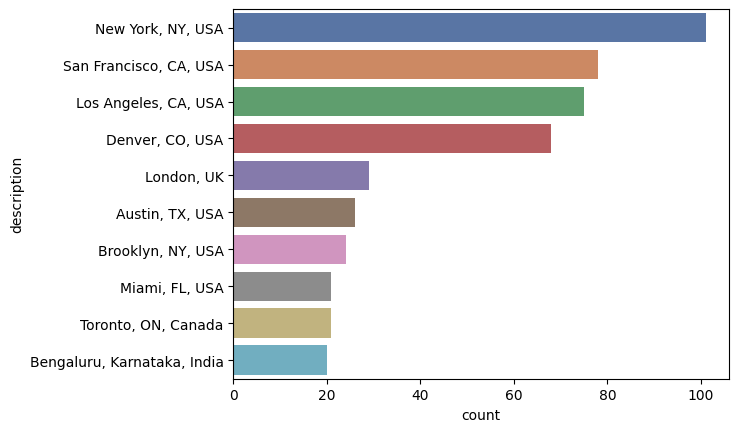

In [9]:
# you can also use seaborn/matplotlib to visualize things
# ex: plot top 10 farcasters' most frequent locations
import seaborn as sns
import matplotlib.pyplot as plt

# get top 10 farcasters' most frequent locations
query = """
SELECT l.description, COUNT(*) AS count
FROM users u
JOIN locations l ON u.location_id = l.id
WHERE u.farcaster_address IS NOT NULL
GROUP BY l.description
ORDER BY count DESC
LIMIT 10;
"""


with duckdb.connect('datasets/datasets.db') as con:
    df = con.sql(query).df()

sns.barplot(x='count', y='description', data=df, palette="deep")
plt.show()



I hope you enjoy using Warpy!

Complaints, comments, feedback to go @pixel on Farcaster :)
